In [11]:
from fastai import *
from fastai.vision import *
from pathlib import Path

In [86]:
images_dir = Path('/data/faces/IC_1K_MATCHES/HITS/')
image_paths = list(images_dir.iterdir())

In [119]:
from facenet_pytorch import MTCNN
mtcnn = MTCNN(
    image_size=224, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device='cpu'
)

from torchvision import datasets
class ImagesWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index)
        path = self.imgs[index][0]
        return (original_tuple + (path,))

dataset = ImagesWithPath(str(images_dir.parent))
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=lambda x: x[0], num_workers=1)

def create_cropped_images(loader):
    output_bboxes = {}
    for x, y, path in progress_bar(loader):
        batch_boxes, batch_probs = mtcnn.detect(x)
        idx = batch_probs.argmax()
        bbox = batch_boxes[idx]
        l,t,r,b = map(int, bbox)
        output_bboxes[Path(path).name] = (t,l,b,r)
    return output_bboxes
mtcnn_output_bboxes = create_cropped_images(loader)
mtcnn_bboxes = [mtcnn_output_bboxes[im_path.name] for im_path in image_paths]
len(mtcnn_bboxes)

2226

In [177]:
tlbr2hw = lambda bbs: bbs[2:] - bbs[:2] # [4] -> [2]
hw2area = lambda hw: hw[0] * hw[1] # [2] -> []
def intersection(bb1, bb2): # (t,l,b,r) x 2
    intersection_tl_corner = torch.max(bb1[:2], bb2[:2])
    intersection_br_corner = torch.min(bb1[2:], bb2[2:])
    sizes = torch.clamp(intersection_br_corner - intersection_tl_corner, min=0)
    return sizes[0]*sizes[1]

def IoU(bb1, bb2): # (t,l,b,r) x 2
    bb1, bb2 = map(lambda bb: torch.tensor(bb), [bb1, bb2])
    inter = intersection(bb1, bb2).float()
    hw1, hw2 = map(lambda bb: tlbr2hw(bb), [bb1,bb2])
    bb1_area, bb2_area = map(lambda hw: hw2area(hw), [hw1, hw2])
    union = bb1_area + bb2_area - inter
    return float(inter / union)
IoU( [100,100,200,200], [99,99,200,200] )

In [178]:
calc_mtcnn_ious = lambda bboxes: [IoU(bb,mtcnn_bb) for bb,mtcnn_bb in zip(bboxes, mtcnn_bboxes)]

In [181]:
def save_image(im_path, bbox, output_dir, iou=''):
    im = cv2.imread(str(im_path))
    t,l,b,r = map(int, bbox)
    im = cv2.rectangle(im, (l,t), (r,b), (0,255,255), 5)
    cv2.imwrite(str(Path(output_dir)/(str(iou) + '_' + Path(im_path).name)), im)

In [260]:
def save_bboxes(image_paths, bboxes, output_dir, ious=None):
    if not Path(output_dir).exists(): Path(output_dir).mkdir()
    for im_path in Path(output_dir).iterdir(): im_path.unlink()
    if ious is None: [save_image(im_path,bb,output_dir) for im_path, bb in progress_bar(list(zip(image_paths, bboxes)))]
    else: [save_image(im_path,bb,output_dir,int(iou*100)) for im_path,bb,iou in progress_bar(list(zip(image_paths, bboxes, ious)))]

In [197]:
from facelib.core import plot
def show_points(im_path, bbox, title=''):
    im = cv2.imread(str(im_path))
    t,l,b,r = map(int, bbox)
    im = cv2.rectangle(im, (l,t), (r,b), (0,255,255), 5)
    plot(im[:,:,[2,1,0]])

In [138]:
save_bboxes(image_paths, mtcnn_bboxes, '../data/face_detection/mtcnn/')

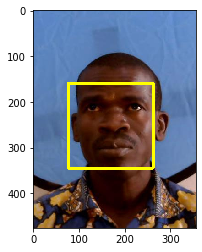

In [194]:
import face_recognition
def dlib_face_detection(im_path):
    image = face_recognition.load_image_file(im_path)
    try: t,r,b,l = face_recognition.face_locations(image, model='hog')[0]
    except: return (0,0,0,0)
    return (t,l,b,r)
show_points(image_paths[0], dlib_face_detection(image_paths[0]))

In [192]:
dlib_hog_bboxes = [dlib_face_detection(im_path) for im_path in progress_bar(image_paths)]
ious = calc_mtcnn_ious(dlib_hog_bboxes)
save_bboxes(image_paths, dlib_hog_bboxes, '../data/face_detection/dlib_hog/', ious)
print(np.mean(ious))

0.7192434259662731


In [128]:
from facelib.core import plot
def show_points(im_path, bbox, title=''):
    im = cv2.imread(str(im_path))
    t,l,b,r = map(int, bbox)
    im = cv2.rectangle(im, (l,t), (r,b), (0,255,255), 5)
    plot(im[:,:,[2,1,0]])

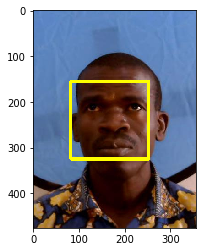

In [129]:
bb = dlib_face_detection(image_paths[0])
show_points(image_paths[0], (bb[0],bb[1],bb[2],bb[3]))

In [254]:
a = [(0,1), (1,2), (5,1), (3,5)]
for b in sorted(a, key=lambda x: x[0], reverse=True):
    print(b)

(5, 1)
(3, 5)
(1, 2)
(0, 1)


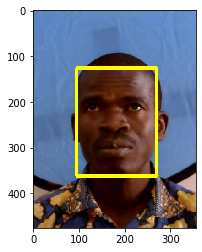

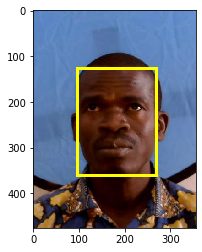

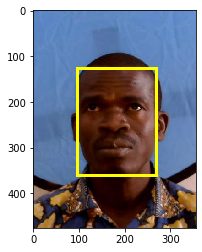

In [290]:
import cv2
model_dir=Path('../models/opencv/')
net_fp16 = cv2.dnn.readNetFromCaffe(str(model_dir/"deploy.prototxt.txt"), str(model_dir/"res10_300x300_ssd_iter_140000_fp16.caffemodel"))
net_fp32 = cv2.dnn.readNetFromCaffe(str(model_dir/"deploy.prototxt.txt"), str(model_dir/"res10_300x300_ssd_iter_140000.caffemodel"))
net_uint8 = cv2.dnn.readNetFromTensorflow(str(model_dir/"opencv_face_detector_uint8.pb"), str(model_dir/"opencv_face_detector.pbtxt"))

detections2middle_xy = lambda d: ((d[:,3]+d[:,5])/2, (d[:,4]+d[:,6])/2)

def opencv_face_detection(im, net=net_uint8, im_path=True, thresh=0.9, means=[104, 177, 123]):
    if im_path: im = cv2.imread(str(im))
    frameHeight, frameWidth = im.shape[0], im.shape[1]
    blob = cv2.dnn.blobFromImage(im, 1.0, (300, 300), means, False, False)
    net.setInput(blob)
    detections = net.forward().squeeze() # [1,1,200,7] -> [200,7]
    detections = np.array([detection for detection in detections if detection[2] > thresh])
    if len(detections) == 0: return (0,0,0,0)
    xs_middle, ys_middle = detections2middle_xy(detections)
    distances = (xs_middle-0.5)**2 + (ys_middle-0.5)**2
    bbox_idx = np.argmin(distances)
    l = int(detections[bbox_idx, 3] * frameWidth)
    t = int(detections[bbox_idx, 4] * frameHeight)
    r = int(detections[bbox_idx, 5] * frameWidth)
    b = int(detections[bbox_idx, 6] * frameHeight)
    return (t,l,b,r)

show_points(image_paths[0], opencv_face_detection(image_paths[0], net=net_uint8))
show_points(image_paths[0], opencv_face_detection(image_paths[0], net=net_fp16))
show_points(image_paths[0], opencv_face_detection(image_paths[0], net=net_fp32))

In [286]:
cv2.dnn.blobFromImage??

In [214]:
def cascade_detect_regions(img, cascade_classifier):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    img_gray = cv2.equalizeHist(img_gray)
    regions = cascade_classifier.detectMultiScale(img_gray)
    return [ list(map(int, (t,l,t+h,l+w))) for (l,t,w,h) in regions] # out: (t,l,b,r)

face_cascade = cv2.CascadeClassifier()
face_cascade.load(cv2.samples.findFile('../models/opencv/haarcascade_frontalface_default.xml'))
detect_faces = lambda img: cascade_detect_regions(img, face_cascade)

points2area = lambda x: ((x[2]-x[0])*(x[3]-x[1]))
def opencv_haar_face_detection(img, im_path=True):
    if im_path: img = cv2.imread(str(img))
    for t,l,b,r in sorted(detect_faces(img), key=lambda pts: points2area(pts))[::-1]:
        return (t,l,b,r)
    return (0,0,0,0)

In [261]:
cvhaar_bboxes = [opencv_haar_face_detection(im_path) for im_path in progress_bar(image_paths)]
ious = calc_mtcnn_ious(cvhaar_bboxes)
save_bboxes(image_paths, cvhaar_bboxes, '../data/face_detection/cv_haar/', ious)
print('haar', np.mean(ious))

haar 0.671435186184854


In [291]:
for name, net in [('cvdnn_uint8',net_uint8), ('cvdnn_fp16',net_fp16), ('cvdnn_fp32',net_fp32)]:
    cvdnn_bboxes = [opencv_face_detection(im_path, net=net) for im_path in progress_bar(image_paths)]
    ious = calc_mtcnn_ious(cvdnn_bboxes)
    save_bboxes(image_paths, cvdnn_bboxes, f'../data/face_detection/{name}/', ious)
    print(name, np.mean(ious))

cvdnn_uint8 0.8946738598428111


cvdnn_fp16 0.8952860714129682


cvdnn_fp32 0.8952742852504898


In [314]:
for name, net in [('cvdnn_uint8',net_uint8), ('cvdnn_fp16',net_fp16), ('cvdnn_fp32',net_fp32)]:
    cvdnn_bboxes = [opencv_face_detection(im_path, net=net, means=[210, 187, 5]) for im_path in progress_bar(image_paths)]
    ious = calc_mtcnn_ious(cvdnn_bboxes)
#     save_bboxes(image_paths, cvdnn_bboxes, f'../data/face_detection/{name}/', ious)
    print(name, np.mean(ious))

cvdnn_uint8 0.9005857412330973


cvdnn_fp16 0.8995865924285535


cvdnn_fp32 0.899578970022707


In [283]:
means = np.random.randint(255, size=(10,3))
means

array([[ 68,  20,  70],
       [197, 224,  27],
       [116, 140,   1],
       [133, 194,  13],
       [174, 220, 208],
       [128, 170,  55],
       [ 78, 186, 176],
       [ 68, 167, 117],
       [ 68, 211, 164],
       [ 89, 236,  70]])

In [324]:
out = []
for mean in progress_bar(np.random.randint(255, size=(1000,3))):
    mean = list(map(int, mean))
    cvdnn_bboxes = [opencv_face_detection(im_path, net=net_fp16, means=mean) for im_path in image_paths[:300]]
    ious = calc_mtcnn_ious(cvdnn_bboxes[:300])
    out.append((np.mean(ious), mean))

In [315]:
sorted(out, key=lambda x: x[0], reverse=True)[:10]

[(0.8993811119794846, [210, 187, 5]),
 (0.8989805535078049, [197, 208, 52]),
 (0.8978197565078735, [250, 198, 53]),
 (0.897741768360138, [176, 233, 114]),
 (0.8976016994714737, [197, 222, 59]),
 (0.8975998309850692, [242, 199, 74]),
 (0.8975779148340225, [236, 144, 39]),
 (0.8970715938806534, [187, 110, 21]),
 (0.8970276812314987, [184, 73, 0]),
 (0.8965087136030198, [79, 145, 42])]

In [323]:
out_plot

[(0.8782972993850708, [243, 119, 153]),
 (0.8769723490476609, [236, 104, 172]),
 (0.8762742468118667, [150, 132, 241]),
 (0.8756458140611648, [98, 54, 206]),
 (0.8752240943908691, [7, 127, 214]),
 (0.8750704144239425, [82, 87, 251]),
 (0.8748893237113953, [69, 128, 246]),
 (0.8740211770534515, [131, 30, 137]),
 (0.8730103254318238, [169, 163, 253]),
 (0.8712793953418732, [198, 3, 23]),
 (0.8689378408640623, [192, 31, 117]),
 (0.8675806314945221, [80, 51, 229]),
 (0.8630596761703491, [220, 115, 230]),
 (0.8624425525665284, [10, 90, 237]),
 (0.8335128186643124, [118, 12, 189]),
 (0.8250271904468537, [192, 34, 153]),
 (0.8233424229621887, [113, 229, 48]),
 (0.8210772249996662, [240, 20, 91]),
 (0.8101734010130167, [92, 5, 210]),
 (0.767863586395979, [10, 186, 38]),
 (0.7678284919559956, [38, 211, 71]),
 (0.7370575000941754, [23, 188, 9]),
 (0.6677177287191153, [14, 206, 46]),
 (0.6502920635342598, [213, 41, 192]),
 (0.6327564107328654, [39, 220, 33]),
 (0.6039821613878011, [155, 12, 223])

<IPython.core.display.Javascript object>


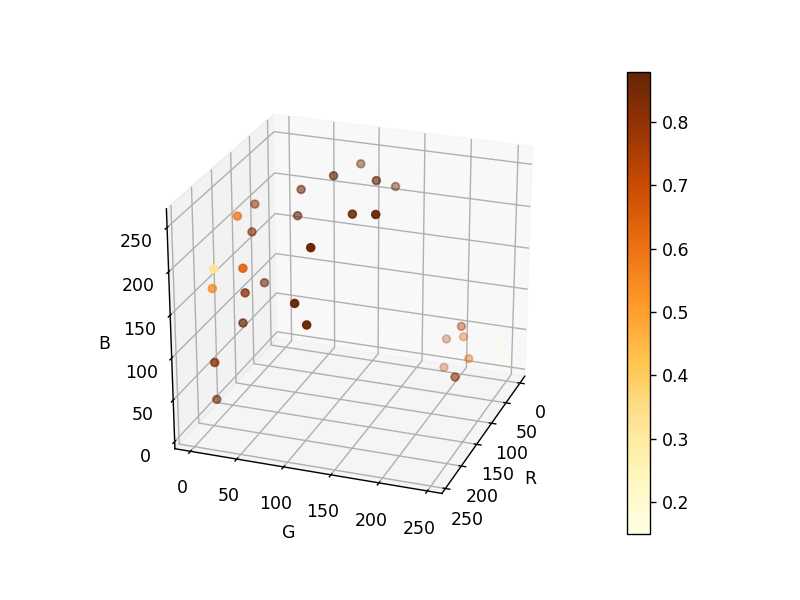

In [321]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

out_plot = sorted(out, key=lambda x: x[0], reverse=True)[70:]

x = [r for iou, (r,g,b) in out_plot]
y = [g for iou, (r,g,b) in out_plot]
z = [b for iou, (r,g,b) in out_plot]
c = [iou for iou, (r,g,b) in out_plot]

img = ax.scatter(x, y, z, c=c, cmap=plt.get_cmap('YlOrBr'))
fig.colorbar(img)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
plt.show()

In [269]:
for name, net in [('cvdnn_fp16',net_fp16), ('cvdnn_fp32',net_fp32)]:
    cvdnn_bboxes = [opencv_face_detection(im_path, net=net_fp16, means=[136, 124, 121]) for im_path in progress_bar(image_paths)]
    ious = calc_mtcnn_ious(cvdnn_bboxes)
    print(name, np.mean(ious))

cvdnn_uint8 0.8920815851060743


cvdnn_fp16 0.892633614675054


cvdnn_fp32 0.8926509250045787


# Speed

In [226]:
np.mean??

In [232]:
for im_path in image_paths[:100]:
    im = tensor(cv2.imread(str(im_path))[:,:,[2,1,0]]).float().mean(dim=(0,1))
    print(im.shape)
    a = tensor(im).float().mean(dim=(0,1))
#     a = np.mean(im, axis=2)
    print(a)
    break

(476, 356, 3)
tensor([ 85.1338,  86.6890, 107.8325])


In [243]:
means = [tensor(cv2.imread(str(im_path))[:,:,[2,1,0]]).float().mean(dim=(0,1))[None] for im_path in image_paths]

In [245]:
ic_mean_stats = torch.cat(means, dim=0).mean(0)
ic_mean_stats

tensor([136.5999, 124.2471, 120.9064])

In [208]:
images = [cv2.resize(cv2.imread(str(im_path)), (300,300)) for im_path in image_paths[:100]]

In [209]:
%%timeit
opencv_face_detection(images[0], net=net_uint8, im_path=False)

15.8 ms ± 90.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [206]:
%%timeit
opencv_face_detection(images[0], net=net_fp16, im_path=False)

16.5 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [207]:
%%timeit
opencv_face_detection(images[0], net=net_fp32, im_path=False)

16.4 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [215]:
%%timeit
opencv_haar_face_detection(images[0], im_path=False)

12.8 ms ± 536 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
